In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
#importing data
stats = pd.read_csv('fantasy.txt')
#replacing all NAs with 0
stats.fillna(value = 0, inplace = True)

#filtering for players that only had greater than 0 points
stats = stats[stats.FantPt >= 16]


#first we will reorder the dataframe from highest to lowest points scored
#normal leagues
stats_norm = stats.sort_values('FantPt', ascending = False)
#ppr leagues
stats_ppr = stats.sort_values('PPR', ascending = False)

#list of predictors
predictors = ['Player', 'G', 'GS', 'Cmp', 'Att', 'Yds', 'TD', 'Int', 'Att.1',
              'Yds.1', 'Y/A', 'TD.1', 'Tgt', 'Rec', 'Yds.2', 'Y/R',
              'TD.2', 'Fmb', 'FL', 'TD.3', '2PM', '2PP', 'FantPt',
              'PPR']

#all relevant predictors to use for PCA
test = stats.filter(items = predictors)
#storing index as player names
test.set_index('Player', inplace = True)

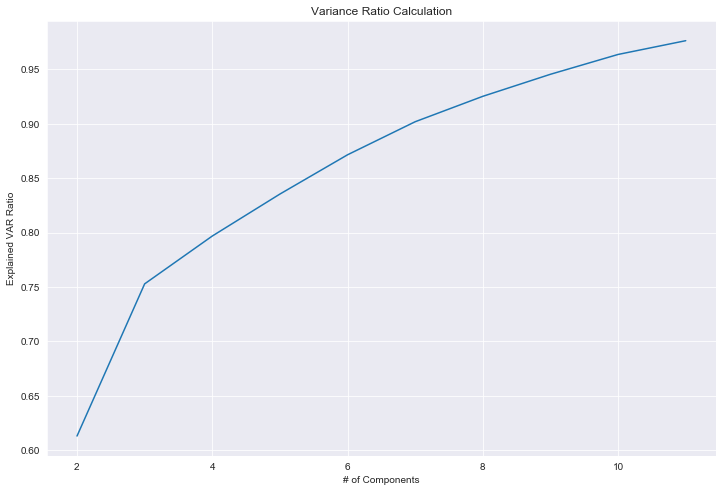

In [48]:
#standardizing data
test = StandardScaler().fit_transform(test)
###################Performing PCA
pca_variance_list = []
#for loop that serachs for best ratio
for i in range(2,12):
    pca = PCA(i)
    components = pca.fit_transform(test)
    pca_variance = sum(pca.explained_variance_ratio_)
    pca_variance_list.append(pca_variance)
#plotting our variance
#changing style
sns.set_style('darkgrid')
#changing fig size
plt.figure(figsize = (12,8))
#plotting our variance
ax = sns.lineplot(range(2,12), pca_variance_list)
ax.set(xlabel = '# of Components', ylabel = 'Explained VAR Ratio', 
       title = 'Variance Ratio Calculation')
plt.show()

Since we can't tell much from this graph we will instead calculate the difference between clusters. So, the difference between 4 to 5, 5 to 6, etc. (essentially the derivative at each point.

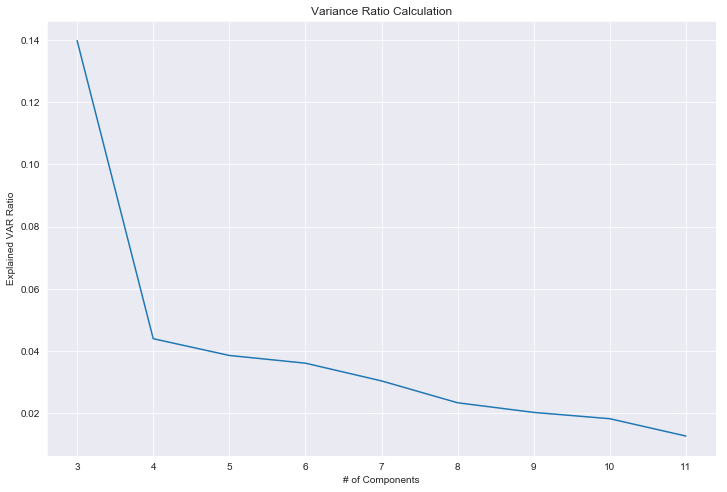

In [49]:
dy = np.diff(pca_variance_list)
#changing fig size
plt.figure(figsize = (12,8))
#plotting our variance
ax = sns.lineplot(range(3,12), dy)
ax.set(xlabel = '# of Components', ylabel = 'Explained VAR Ratio', 
       title = 'Variance Ratio Calculation')
plt.show()

In [45]:
#getting our data in 3 PCA
#running PCA
pca = PCA(3)
#getting our components
components = pca.fit_transform(test)
#getting our new dataframe
pca_df = pd.DataFrame(components, columns = ['PC 1', 'PC 2', 'PC 3'])
#adding player names
pca_df['Player'] = test.index.values
#checking our variance ratio
sum(pca.explained_variance_ratio_)

0.999270258659444

As we can see there is a sharp decrease as we move from 3 components to 4 components. This tells us that when we increase our number of principal components from 3 to 4 our explained variance ratio only increases slightly. So, to keep our model simplier we will use 3 components. In essence, we condensed our data down to only 3 columns that account for 99% of information from our original 23 columns. Now we can move on to clustering.

# Gaussian Mixture Modeling

For our first model we will be using Gaussian Mixture. Just like when we used our